### Project

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import datacube

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
dc = datacube.Datacube(app='project')

In [3]:
lake_naivasha = gpd.read_file('data/nairobi_metro.shp')
lake_naivasha.explore()

In [4]:
extent = lake_naivasha.total_bounds
extent

array([36.58955126, -1.69136116, 37.42310586, -0.94474754])

In [5]:
x_range = (extent[0], extent[2])
y_range = (extent[1], extent[3])

In [6]:
ds_gm_2020 = dc.load(
         product='gm_s2_annual',
         output_crs='epsg:6933',
         resolution=(-20,20),
         y= y_range,
         x=x_range,
         time=('2020'),
         measurements = ['red','green','blue','nir','swir_1','swir_2'],
        )
ds_gm_2020 = ds_gm_2020.squeeze()

ds_dem = dc.load(
         product='dem_srtm',
         output_crs='epsg:6933',
         resolution=(20, 20),
         y= y_range,
         x=x_range,
         time=('2020'),
         measurements = ['elevation'],
        )
ds_dem = ds_dem.squeeze()

In [7]:
ds_gm_2020 = calculate_indices(ds_gm_2020, 
                              index=['NDBI'],
                              satellite_mission='s2'
                             )

In [8]:
ndbi = ds_gm_2020['NDBI'].where(ds_gm_2020['NDBI'] > 0)

In [9]:
class_label=['not_suitable','suitable','very_suitable']
class_number=[0, 1, 2]
class_color=['red','yellow','green']
cp = mcolors.ListedColormap(class_color, N=len(class_color))

condition = [
    (ds_dem['elevation'] < 1600),
    (ds_dem['elevation'] >= 1600)&(ds_dem['elevation'] < 2000),
    (ds_dem['elevation'] >= 2000)
]

selection = np.select(condition, class_number)
ds_dem['categorised_dem'] = (xr.DataArray(selection,
                                        coords={
                                                'y':ds_dem.y,
                                                'x':ds_dem.x},
                                        dims = ['y','x']))

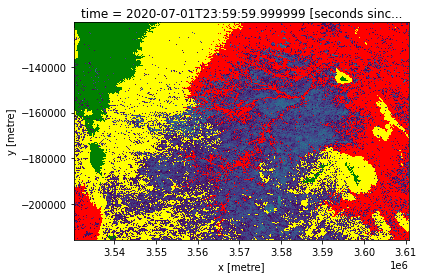

In [10]:
ds_dem['categorised_dem'].plot(add_colorbar=False, cmap=cp)
ndbi.plot(add_colorbar=False)

In [11]:
very_suitable = ndbi.where((ds_dem['categorised_dem'] == 2))
suitable = ndbi.where((ds_dem['categorised_dem'] == 1))
not_suitable = ndbi.where((ds_dem['categorised_dem'] == 0))

In [12]:
c_green = mcolors.ListedColormap('green')
c_yellow = mcolors.ListedColormap('yellow')
c_red = mcolors.ListedColormap('red')

In [13]:
pl = 20
m_per_km = 1000
area_per_pixel_km = pl ** 2 / 1000

In [14]:
very_suitable_area = very_suitable.count() * area_per_pixel_km
suitable_area = suitable.count() * area_per_pixel_km
not_suitable_area = not_suitable.count() * area_per_pixel_km

In [15]:
import pandas as pd

In [21]:
df = pd.DataFrame([not_suitable_area.values,
                    suitable_area.values, 
                   very_suitable_area.values
                    ],
                  columns=['area'],
                  index=class_label
                  
                 )

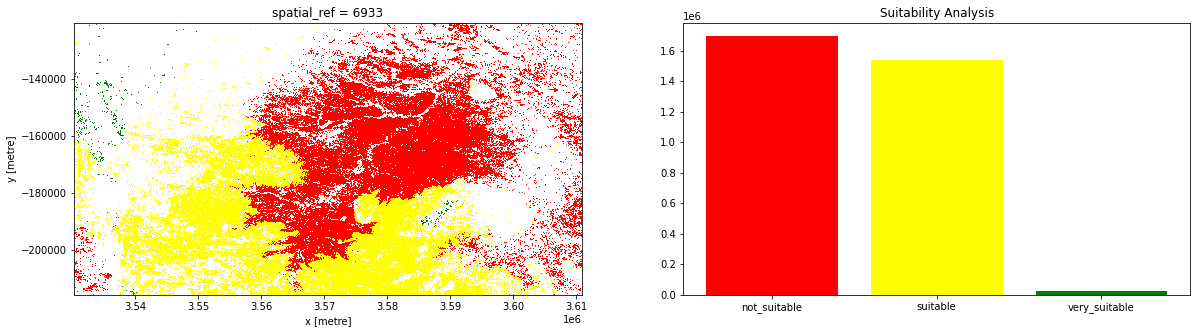

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

very_suitable.plot(add_colorbar=False, cmap=c_green, ax=ax[0])
suitable.plot(add_colorbar=False, cmap=c_yellow, ax=ax[0])
not_suitable.plot(add_colorbar=False, cmap=c_red, ax=ax[0])


plt.bar(x = df.index, height=df['area'], color=class_color)

plt.title('Suitability Analysis')
plt.show()